## Import Library

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE 

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

#Other library outside the template
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     RandomizedSearchCV)
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)

## Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

telcochurn=pd.read_csv('/content/drive/MyDrive/Dibimbing/data/Telco-Customer-Churn.csv')

telcochurn.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#Data Understanding

In [ ]:
telcochurn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
telcochurn.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# Data Preprocessing

##Data Cleaning

In [ ]:
# Detect missing value

telcochurn.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
#Check duplicated values
telcochurn.duplicated().sum()

0

In [ ]:
#Look at TotalCharges data type, Its type is object, should be convert to be float
#checking the data which index starting not float type

row=0
for entry in telcochurn['TotalCharges']:
  print(row)
  float(entry)
  row += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

ValueError: ignored

In [ ]:
#Checking index 488

telcochurn.loc[488]['TotalCharges']

' '

Its contains spasi

In [ ]:
#Checking how many indexes contain a space, not number

def isnumber(x):
  try:
    float(x)
    return True
  except:
    return False
telcochurn['isnumber']=telcochurn['TotalCharges'].apply(isnumber)
index_isnotnumber=telcochurn[~telcochurn['isnumber']].index

In [ ]:
telcochurn[~telcochurn['isnumber']]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,isnumber
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,False
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,False
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,False
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,False
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,False
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,False
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,False
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,False
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,False
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,False


In [ ]:
#fill TotalCharges not number with the median
#Seeking median of TotalCharges
median=telcochurn[telcochurn['isnumber']]['TotalCharges'].astype('float').median()

In [ ]:
#Showing the median
median

1397.475

In [ ]:
#Replace 11 data of TotalCharges which are not float with median
telcochurn.loc[index_isnotnumber, 'TotalCharges']=median

In [ ]:
#Crosscheck data
telcochurn.loc[index_isnotnumber].dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
isnumber               bool
dtype: object

In [ ]:
#As the result above, Totalcharges has not been float data, let's change it to be float
telcochurn['TotalCharges']=telcochurn['TotalCharges'].astype('float64')

In [ ]:
#Recheck
telcochurn.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
isnumber               bool
dtype: object

In [ ]:
# Set senior citizen to type category
telcochurn['SeniorCitizen'] = telcochurn['SeniorCitizen'].map({1: 'yes', 0: 'no'}).astype('category')

In [ ]:
#Check info of continious feature
print(telcochurn.info())  #Conversion sucsessful
print(telcochurn.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   object  
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   object  
 4   Dependents        7043 non-null   object  
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   object  
 7   MultipleLines     7043 non-null   object  
 8   InternetService   7043 non-null   object  
 9   OnlineSecurity    7043 non-null   object  
 10  OnlineBackup      7043 non-null   object  
 11  DeviceProtection  7043 non-null   object  
 12  TechSupport       7043 non-null   object  
 13  StreamingTV       7043 non-null   object  
 14  StreamingMovies   7043 non-null   object  
 15  Contract          7043 non-null   object  
 16  PaperlessBilling  7043 n

In [ ]:
#Drop unique column (Column that we will not analyze)
telcochurn=telcochurn.drop(columns='customerID')


In [ ]:
#Drop isnumber column (Column that we will not analyze)
telcochurn=telcochurn.drop(columns='isnumber')

Good! Data ready to be used..

In [ ]:
telcochurn.head(1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,no,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


####Covert `No Internet Service` to No

We need to categorize the categorical variables related to spesific internet services from multiclass to binary. All customers that do not have a specialized internet service because they do not have internet sevices at all are recoded.

In [ ]:
# 6 features, convert 'no internet service' to 'No'
no_int_service_vars = ['OnlineSecurity','OnlineBackup','DeviceProtection',
                       'TechSupport','StreamingTV','StreamingMovies']
       
              
for var in no_int_service_vars:
  telcochurn[var] = telcochurn[var].map({'No internet service': 'No', 'Yes':'Yes',
                                         'No':'No'}).astype('category')

for var in no_int_service_vars:
  print(telcochurn[var].value_counts())

No     5024
Yes    2019
Name: OnlineSecurity, dtype: int64
No     4614
Yes    2429
Name: OnlineBackup, dtype: int64
No     4621
Yes    2422
Name: DeviceProtection, dtype: int64
No     4999
Yes    2044
Name: TechSupport, dtype: int64
No     4336
Yes    2707
Name: StreamingTV, dtype: int64
No     4311
Yes    2732
Name: StreamingMovies, dtype: int64


#####Now, let's iterate through all of the categorical variables and plot their distributions.

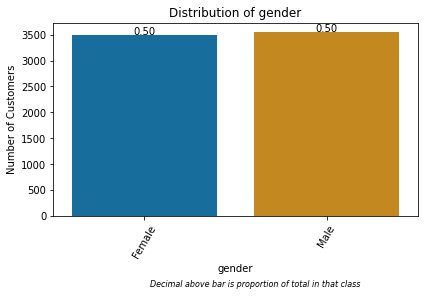

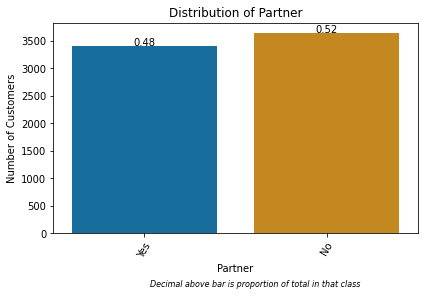

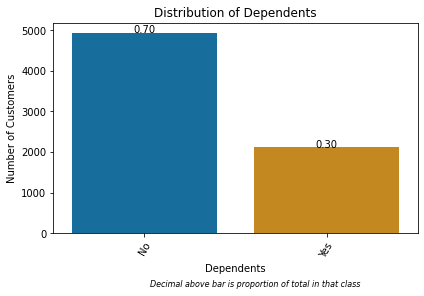

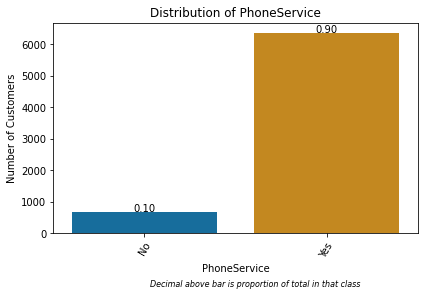

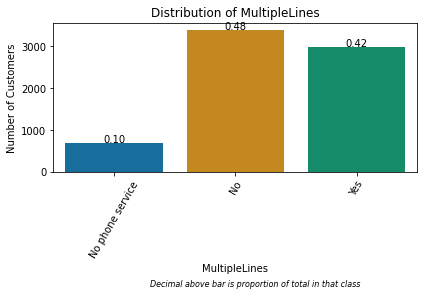

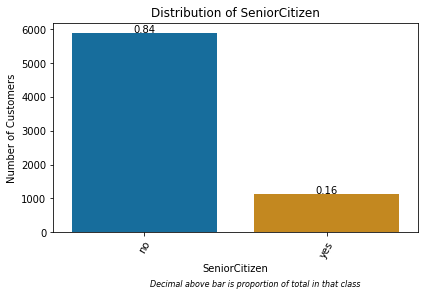

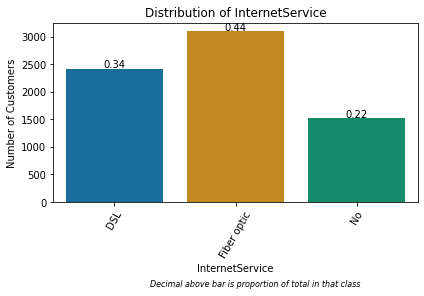

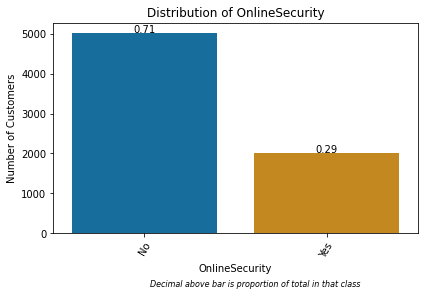

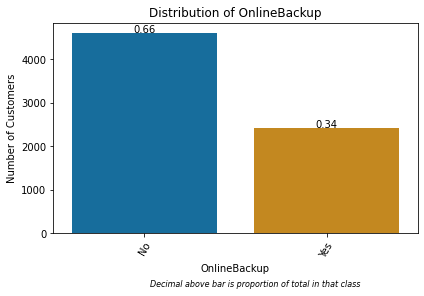

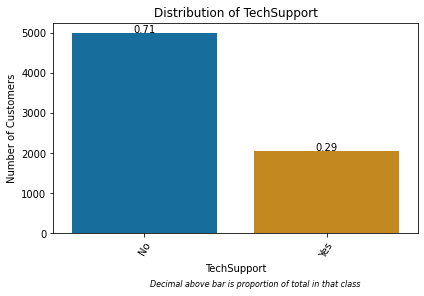

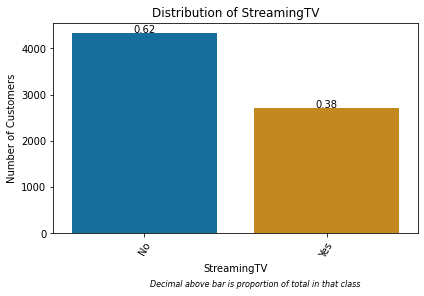

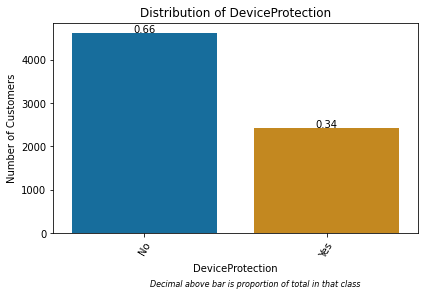

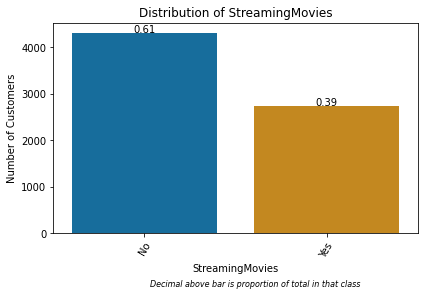

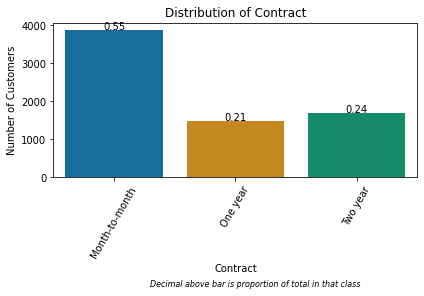

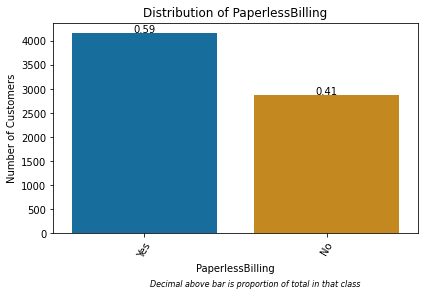

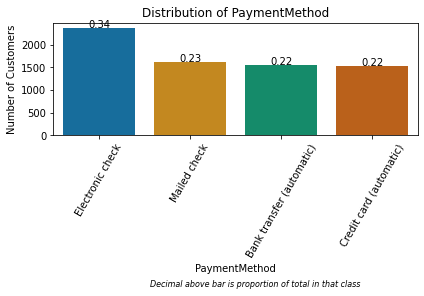

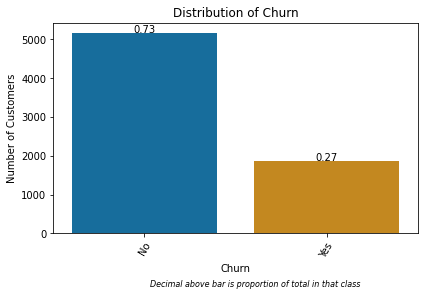

In [ ]:
#Define list of categorical variables
cat_var = ['gender','Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'SeniorCitizen',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV',
                'DeviceProtection', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


#Plot distributions of categorical variables
for var in cat_var:
    ax = sns.countplot(x = telcochurn[var], data=telcochurn, palette = 'colorblind')
    total = float(len(telcochurn[var]))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 10,
                '{:1.2f}'.format(height/total),
                ha='center')   
    plt.title('Distribution of ' + str(var))
    plt.ylabel ('Number of Customers')
    plt.figtext(0.6, -0.01 ,
            'Decimal above bar is proportion of total in that class',
            horizontalalignment = 'center', fontsize = 8,
            style='italic')
    plt.xticks(rotation = 60)
    plt.tight_layout()
    plt.savefig('plot_dist-' + str(var) + '.png', dpi=200)
    plt.show()

##### Detect Outliers

In [ ]:
#Group column names based on type

num_var = ['MonthlyCharges','TotalCharges', 'tenure']

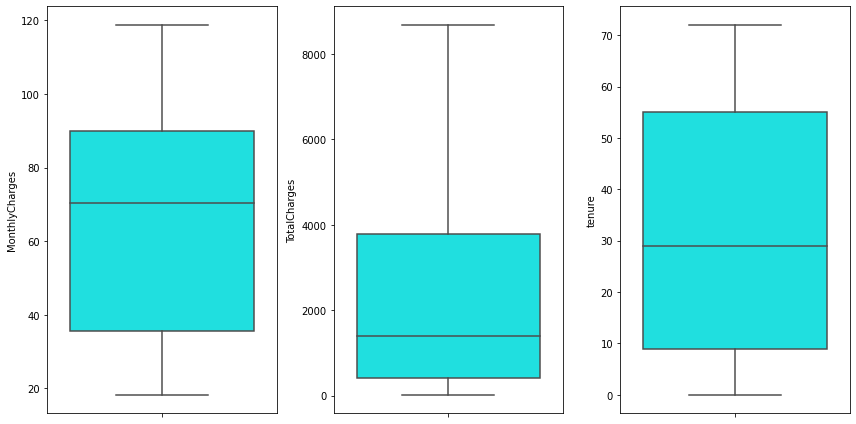

In [ ]:
# adjust the figure size for better readability
plt.figure(figsize=(12,6))

# plotting
features = num_var
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=telcochurn[features[i]], color='cyan')
    plt.tight_layout()

Good, No outlier detected.

###Standarization

In [ ]:
#Standarize continuous variables for distance based models
scale_vars=['tenure', 'MonthlyCharges']
scaler = StandardScaler()
telcochurn[scale_vars] = scaler.fit_transform(telcochurn[scale_vars])
telcochurn[scale_vars].describe

<bound method NDFrame.describe of         tenure  MonthlyCharges
0    -1.277445       -1.160323
1     0.066327       -0.259629
2    -1.236724       -0.362660
3     0.514251       -0.746535
4    -1.236724        0.197365
...        ...             ...
7038 -0.340876        0.665992
7039  1.613701        1.277533
7040 -0.870241       -1.168632
7041 -1.155283        0.320338
7042  1.369379        1.358961

[7043 rows x 2 columns]>

In [ ]:
#Binarize binary variables
telcochurn_enc=telcochurn.copy()
binary_vars=['gender','Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'SeniorCitizen',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV',
                'DeviceProtection', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
enc = LabelEncoder()
telcochurn_enc[binary_vars] = telcochurn_enc[binary_vars].apply(enc.fit_transform)

##OneHot encode multi-category cat.variables
multicat_vars = ['InternetService','Contract','PaymentMethod']
telcochurn_enc = pd.get_dummies (telcochurn_enc, columns = multicat_vars)
telcochurn_enc.iloc[:,16:26] = telcochurn_enc.iloc[:,16:26].astype(int)
print(telcochurn_enc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   int64  
 1   SeniorCitizen      7043 non-null   int64  
 2   Partner            7043 non-null   int64  
 3   Dependents         7043 non-null   int64  
 4   tenure             7043 non-null   float64
 5   PhoneService       7043 non-null   int64  
 6   MultipleLines      7043 non-null   int64  
 7   OnlineSecurity     7043 non-null   int64  
 8   OnlineBackup       7043 non-null   int64  
 9   DeviceProtection   7043 non-null   int64  
 10  TechSupport        7043 non-null   int64  
 11  StreamingTV        7043 non-null   int64  
 12  StreamingMovies    7043 non-null   int64  
 13  PaperlessBilling   7043 non-null   int64  
 14  MonthlyCharges     7043 non-null   float64
 15  TotalCharges       7043 non-null   float64
 16  Churn              7043 

###Correlation 

In [ ]:
#Examine Correlations
telcochurn['tenuremonth']= (telcochurn['tenure']*telcochurn['MonthlyCharges']).astype(float)
telcochurn.corr()

,tenure,MonthlyCharges,TotalCharges,tenuremonth
tenure,1.000000,0.247900,0.825464,0.054086
MonthlyCharges,0.247900,1.000000,0.650864,0.145161
TotalCharges,0.825464,0.650864,1.000000,0.427800
tenuremonth,0.054086,0.145161,0.427800,1.000000


`TotalCharges` has strong correlation with `tenure` and `MonthlyCharges`. We will remove TotalCharges during the feature selection later.

The factor probably because TotalCharges is essentially the multiplication of tenure by MonthlyCharges. Thus we will retain only tenure and MonthlyCharges as features for modeling

In [ ]:
#Drop TotalCharges
telcochurn=telcochurn.drop(columns='TotalCharges')

KeyError: ignored

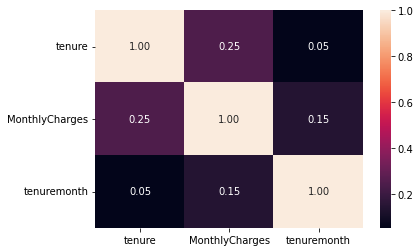

In [ ]:
#Correlation Heatmap
correlation=telcochurn.corr()
sns.heatmap(correlation,annot=True,fmt='.2f')

##Split Data

In [ ]:
X = telcochurn_enc.drop('Churn', axis=1)
y= telcochurn_enc['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                   stratify = y, random_state = 42 )

### KNN Model

In [ ]:
knn = KNeighborsClassifier()

## Set up hyperparameter grid for tuning
knn_param_grid = {'n_neighbors' : np.arange(5,26),
                 'weights' : ['uniform', 'distance']}

#Tune hyperparameters
knn_cv = GridSearchCV (knn, param_grid = knn_param_grid, cv=5)

## Fit knn to training data
knn_cv.fit(X_train, y_train)

# Get info about best hyperparameters
print('Tuner KNN Parameters: {}'.format(knn_cv.best_params_))
print('Best KNN Training Score:{}'.format(knn_cv.best_score_))

#Predict knn on test data
print('KNN Test Performance: {}'.format(knn_cv.score(X_test, y_test)))

#Obtain model performance metrics
knn_pred_prob = knn_cv.predict_proba(X_test)[:,1]
knn_auroc = roc_auc_score(y_test, knn_pred_prob)
print('KNN AUROC: {}'.format(knn_auroc))
knn_y_pred = knn_cv.predict(X_test)
print(classification_report(y_test, knn_y_pred))

Tuner KNN Parameters: {'n_neighbors': 6, 'weights': 'uniform'}
Best KNN Training Score:0.7564776099643657
KNN Test Performance: 0.7735982966643009
KNN AUROC: 0.698922731147795
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1035
           1       0.70      0.26      0.38       374

    accuracy                           0.77      1409
   macro avg       0.74      0.61      0.62      1409
weighted avg       0.76      0.77      0.73      1409



## Logistic Regression

In [ ]:
#Instatntiate classifier 
lr = LogisticRegression(random_state = 42)

## Set up hyperparameter grid for tunning
lr_param_grid = {'C' : [0.0001, 0.001, 0.01, 0.05, 0.1]}

#Tune Hyperparameters
lr_cv= GridSearchCV(lr, param_grid = lr_param_grid,)

#Fit lr to training data
lr_cv.fit(X_train, y_train)

##Get info about best hyperparameters
print('Tuned LR Parameters: {}'.format(lr_cv.best_params_))
print('Best LR Training Score:{}'.format(lr_cv.best_score_))

#Predict lr on test data
print('LR Test Performance:{}'.format(lr_cv.score(X_test, y_test)))

##Obtain model performance metrics
lr_pred_prob = lr_cv.predict_proba(X_test)[:,1]
lr_auroc = roc_auc_score(y_test, lr_pred_prob)
print('LR AUROC: {}'.format(lr_auroc))
lr_y_pred = lr_cv.predict(X_test)

Tuned LR Parameters: {'C': 0.1}
Best LR Training Score:0.8013834493562657
LR Test Performance:0.7955997161107168
LR AUROC: 0.8375080730579452


##Random Forest


In [ ]:
## Instatiate Classifier
rf = RandomForestClassifier(random_state = 42)

## Set up hyperparameter grid for tuning
rf_param_grid ={'n_estimators': [200, 250, 300, 350, 400, 450,500],
                'max_features': ['sqrt', 'log2'],
                'max_depth': [3,4,5,6,7],
                'min_samples_split': [2,5,10,20],
                'min_samples_leaf': [1,2,4]}

##Tune Hyperparameters
rf_cv = RandomizedSearchCV(rf, param_distributions = rf_param_grid, cv=5,
                           random_state = 42, n_iter = 20)

## Fit RF to training data

rf_cv.fit(X_train, y_train)

#Get info about best hyperparameters
print('Tuned RF Parameters: {}'.format(rf_cv.best_params_))
print('Best RF Training Score: {}'.format(rf_cv.best_score_))

#Predict RF in test data
print('RF Test Performance: {}'.format(rf_cv.score(X_test, y_test)))

## Obtain model performance metrics
rf_pred_prob = rf_cv.predict_proba (X_test)[:,1]
rf_auroc = roc_auc_score(y_test, rf_pred_prob)
print('RF AUROC: {}'.format(rf_auroc))
rf_y_pred = rf_cv.predict(X_test)
print(classification_report(y_test, rf_y_pred))

Tuned RF Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 7}
Best RF Training Score: 0.801027421548587
RF Test Performance: 0.8005677785663591
RF AUROC: 0.8453964194373402
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.68      0.48      0.56       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



#### Feature importance in Random Forest Model

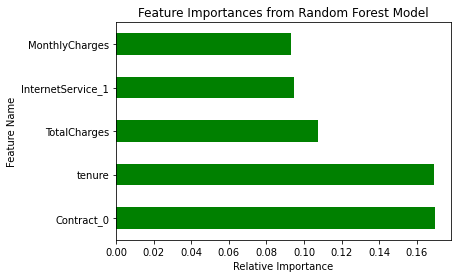

In [ ]:
rf_optimal = rf_cv.best_estimator_
rf_feat_importance = pd.Series(rf_optimal.feature_importances_, index=X_train.columns)
rf_feat_importance.nlargest(5).plot(kind='barh', color='g')
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Name')
plt.savefig('model-rf_feature_importances.png', dpi=200, bbox_inches = 'tight')
plt.show()